# Detecting Sound Interference with Tensorflow for Hangout Sessions
By: Andor Kesselman

In this analysis, we look at sound interference from multiple hangout streams using google hangout. We train and test the data using a neural network.
The goal of this network is to give Google the functionality to enable a "mute" action is multiple audio streams occur on the hangouts at the same time. Frequently, when my colleagues and myself use hangouts, we log in at the same time with our computer. The problem is that multiple microphones on at the same time create an issue with loud feedback loops that greatly disrupt a meeting. Furthermore, often it is difficult to determine which of the incoming channels is responsible for disturbing the audio system. 
We are not audio processing experts, but hope that this simple neural network may provide enough of a baseline to accurately detect multiple audio feedback loops. It would be our hope that it would enable an "action" on Google's side, to mute the interefering audio system and prompt a warning. 

Which type of Classifier do we use? SVM or NN?

### Note: For Prototyping purposes, I'm going to be using PyAudio from
https://github.com/tyiannak/pyAudioAnalysis

https://github.com/tracek/Ornithokrites

I would like to re-evaluate the classification algorithms

So we've plotted the values. Now we neeed to do some form of classification. 
To generate this, we create our own training and test set. 
First, we generate a single interference instance using google hangouts for ~5 mintues. 
We then then randomly sample 10 seconds from the 5 minutes.
Each sample then input a random noise variant using one of three different methods. 

# Import and Setup

In [13]:
from pylab import*
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import random
import os
from os import listdir
from os.path import isfile, join
import sys

sys.path.insert(0, './lib') #insert lib
import audioFeatureExtraction
import audioTrainTest as aT

In [43]:
#Define Paths
basedir = '/Users/andorkesselman/Documents/rnd/sound/src/'
dataset_dir = basedir + 'datasets/'
inter_dir_base = dataset_dir + 'base/interference_audio'
clean_dir_base = dataset_dir + 'base/clean_audio'
inter_dir_gen = dataset_dir + 'generated/interference_audio/'
clean_dir_gen = dataset_dir + 'generated/clean_audio/'
PLOT_WIDTH  = 15
PLOT_HEIGHT = 3.5


# Dataset Generation

For Dataset generation, we will take existing audio files, induce some noise into the datastream, and then store them locally on the machine. This bootstrapping will allow us to generate lots of training data off of a relatively little sample set. 

During the training phase, these files will be read and split into 5 fold cross validation set. 

There are a couple reservations that I have regarding dataset generation. Firstly, my top concern is variety of data. I can add noise, but I do not think there will be enough variety in the datasets to properly train the data. For example, I will not have different languages. 

In [17]:
# Generate Samples from Base Files and Write them to the Output Directory. 
# Adjust the parameters to tune the interations

def generateSamples(base_dir, out_dir, suffix):
    
    print('Generating Training Data')
    audio_files = listFilesInDirectory(base_dir)
    count = 0
    iterations_per_file = 5 # the amount of sample files to be generate from each base file
    
    for file in audio_files:
        wav, sampleFreq = readWavFile(file)
        while (count < iterations_per_file):
            sample = sampleFile(wav)
            sample = randomNoiseGenerator(sample, sampleFreq)
            writeSample(sample, join(out_dir + str(count) + "_" + suffix + ".wav"))
            count+=1

## Noise Generators

In [18]:
# Given a sample, randomly chooses a type of noise to induce on the sample set. 
# There is a bias toward the original sample type.
def randomNoiseGenerator(sample, sampleFreq):
    r = random.randint(0, 3)
    if r == 0:
        return whiteNoise(sample)
    if r == 1:
        x = band_limited_noise(200, 2000, 44100, 44100)
        x = np.int16(x * (2**15 - 1))
        return x
    else:
        return sample

#Generate White Noise. 
def whiteNoise(array): 
    mean = 0
    std = 1 
    num_samples = 1000
    samples = np.random.normal(mean, std, size=num_samples)
    return array

#Generate Band Limited Noise
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

## .Wav Support

In [49]:
# Read Wav File from Location Specified in Method Call
def readWavFile(wavfile_location):
    print("Reading " + wavfile_location)
    sampleFreq, sample = wavfile.read(wavfile_location)
    sample = sample / (2.**15) #normalize and center
    ch1 = sample[:,0] #take one channel. There are two channels in this scenario
    return ch1, sampleFreq

# Read Wav File from Location Specified in Method Call
def readWavFileAllChannels(wavfile_location):
    print("Reading " + wavfile_location)
    sampleFreq, sample = wavfile.read(wavfile_location)
    sample = sample / (2.**15) #normalize and center
    ch1 = sample[:,0] #take one channel. There are two channels in this scenario
    return sample, sampleFreq
 
# Write Audio Sample To File
def writeSample(sample, outdir):
    wavfile.write(outdir, 44100, sample)

# Randomly Returns a Sample of a File. TODO: Improve Sampling Method. 
# Must Remain a Sequence in this Case because Audio is time dependent. Randomly Sampling would be BAD.
def sampleFile(wav):
    #take random 
    size = int(len(wav) / 5) # take 1/5 of the full file size. TODO: What's the best implemenation?
    i = int(len(wav) - size - 1)
    r = random.randint(0, i) # make sure that we get a full set. Hence the - size
    return wav[r:(r+size), ]


### File Helpers

In [19]:
#Only store the name. Do not store the file, as that would remain in memory.
def listFilesInDirectory(directory):
    ret = []
    for file in listdir(directory):
            ret.append(join(directory, file))
    return ret

### Graphical Helpers

In [72]:
def show_stereo_waveform(samples):

	fig = plt.figure(num=None, figsize=(PLOT_WIDTH, 5), dpi=72, facecolor='w', edgecolor='k')

	channel_1 = fig.add_subplot(211)
	channel_1.set_ylabel('Channel 1')
	channel_1.set_xlim(0,len(samples)) 
	channel_1.set_ylim(-1,1)
	channel_1.plot(samples[:,0])

	channel_2 = fig.add_subplot(212)
	channel_2.set_ylabel('Channel 2')
	channel_2.set_xlabel('Time (s)')
	channel_2.set_ylim(-1, 1)
	channel_2.set_xlim(0,len(samples)) 
	channel_2.plot(samples[:,1])

	plt.show();
	plt.clf();


# Training

In the training data, we will split up all the files in the training set into 5 k-folds, with 3 kfolds for the original training data, 1 k fold for the first test, and then the final validation set.

CNN
http://yerevann.github.io/2015/10/11/spoken-language-identification-with-deep-convolutional-networks/
http://research.microsoft.com/en-us/um/people/dongyu/nips2009/papers/montavon-paper.pdf

SVM
http://www.ee.columbia.edu/~sfchang/course/spr-F05/papers/guo-li-svm-audio00.pdf

# Feature Extraction

OK, going into the project, I thought feature extraction would be relatively simple. I was thinking of just doing something like a nearest neighbor approach using the amplitude and frequencies of the wave as the feature. I quickly found out that to not be the case. This is complicated, and I relied heavily on prior work: http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html for guidance. 

In [78]:
# Feature Extraction
class ExtractFeatures():
      def ExtractFeatures():
            print("Extracting Features")

In [ ]:
#Round 1: NN
class NeuralNetwork():
    print('This is the Neural Network')

In [ ]:
#Round 2: SVM
class SVM():
    print('This is an SVM approach')

# Test

# Validation

# Main

In [75]:
def sampleFileViewer():
    samples, freq = readWavFileAllChannels(clean_dir_base + "/1_clean.wav")
    print(samples[24000:25000, ])
    show_stereo_waveform(samples)
def run():
    #generateSamples(clean_dir_base,clean_dir_gen, "clean")
    #generateSamples(inter_dir_base,inter_dir_gen, "inter")
     sampleFileViewer()

Reading /Users/andorkesselman/Documents/rnd/sound/src/datasets/base/clean_audio/1_clean.wav
[[-0.00518799 -0.05233765]
 [-0.00558472 -0.05197144]
 [-0.00073242 -0.04931641]
 ..., 
 [-0.0227356   0.05969238]
 [-0.0383606   0.09408569]
 [-0.04559326  0.09893799]]


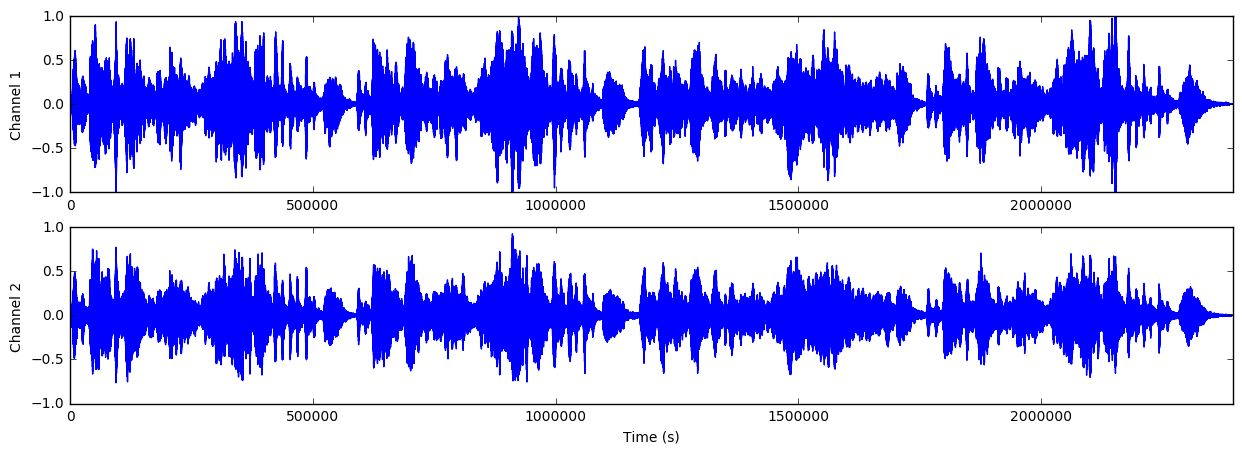

In [76]:
run()